### Imports

In [1]:
#pip install pmdarima

import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import pmdarima as pm

from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.arima.stationarity import ADFTest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape

from pandas.plotting import lag_plot
from pandas.plotting import register_matplotlib_converters

### Some configurations

In [2]:
register_matplotlib_converters() #Register a datetime converter for a matplotlib plotting method
%matplotlib inline

### Define functions for later use

#### Plot the data with different lags

In [3]:
def lag_auto_plot(data):
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    plt.title('MSFT Autocorrelation plot')

    # The axis coordinates for the plots
    ax_idcs = [
        (0, 0),
        (0, 1),
        (1, 0),
        (1, 1),
        (2, 0),
        (2, 1)
    ]

    for lag, ax_coords in enumerate(ax_idcs, 1):
        ax_row, ax_col = ax_coords
        axis = axes[ax_row][ax_col]
        lag_plot(data, lag=lag, ax=axis)
        axis.set_title(f"Lag={lag}")

    plt.show()

#A linear shape to the plot suggests that an autoregressive model is a good choice

#### Forecast one period and update the model with the actual value, to optimize the next predictions

In [4]:
def forecast_one_step(forecastModel):
    fc, conf_int = forecastModel.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

def forecast_and_update_model(model, data):
    forecasts = []
    confidence_intervals = []
    for entry in data.Close:
        fc, conf = forecast_one_step(model)
        forecasts.append(fc)
        confidence_intervals.append(conf)

        # Updates the existing model with a small number of MLE steps
        model.update(entry)
    return (forecasts, confidence_intervals)

#### Plot Actual vs Prediction as well the confidence intervall

In [5]:
#define function for plotting
def plot_prediction_vs_actual(trainData, testData, forecasts, confidence_intervals):
    fig = plt.gcf()
    fig.set_size_inches(16, 9)

    # --------------------- Actual vs. Predicted --------------------------
#    plt.plot(trainData #Train Data
#             color='blue', 
#             label='Train Data')

    plt.plot(testData.index, # Predicted Price
             forecasts, 
             color="green", 
             marker="o",
             label="Predicted Price")
    
    plt.plot(testData.index, #Actual Proce
             testData, 
             color="red", 
             label="Actual Price")
    
    plt.legend(loc="best")
    plt.xlabel("Date")
    plt.ylabel("Volkswagen Closing Price")
    plt.title("Prediction vs Actual")
    plt.grid(True)
    plt.show(block=False)

    # ------------------ Predicted with confidence intervals ----------------
    fig = plt.gcf()
    fig.set_size_inches(16, 9)

#    plt.plot(trainData #Train Data
#             color='blue', 
#             label='Train Data')   

    plt.plot(testData.index, # Predicted Price
             forecasts, 
             color="green", 
             label="Predicted Price")
    
    plt.ylabel("Closing Price Volkswagen")
    plt.xlabel("Date in Months")

    conf_int = np.asarray(confidence_intervals)
    plt.fill_between(testData.index,
                    conf_int[:, 0], conf_int[:, 1],
                    alpha=0.7, color="orange",
                    label="Confidence Intervals")
    plt.legend(loc="best")
    plt.title("Predictions & Confidence Intervals")
    plt.grid(True)
    plt.show(block=False)

#### Evalutate model

In [6]:
def evaluate_model(testData, forecasts):
    print(f"Mean squared error: {mean_squared_error(testData, forecasts)}") 
    print(f"Mean absolut error: {mean_absolute_error(testData, forecasts)}") 
    print(f"SMAPE: {smape(testData, forecasts)}")

### Load the data

In [7]:
dfDataOrig = pd.read_csv("VOW3DE.csv", #import Stock data of Volkswagen
                     parse_dates = True, #Keep date format
                     index_col = "Date", #set the Data column as index
                     squeeze = True)

dfDataDay = dfDataOrig.copy() #Create a copy, so the original data is not modified
dfDataDay = dfDataDay[["Close"]] # Keep only the Close column

#print(dfDataDay.head(5))
#print(dfDataDay.tail(5))
#print(dfDataDay.shape) #(5803, 1)
#print(dfDataDay.index) # dtype='datetime64[ns]', name='Date', length=5803, freq=None

## Day Data

### Split in training und test data

In [8]:
index = round(0.8*len(dfDataDay)) #Use 80% for training
trainDataDay = dfDataDay[:index] 
testDataDay = dfDataDay[index:]

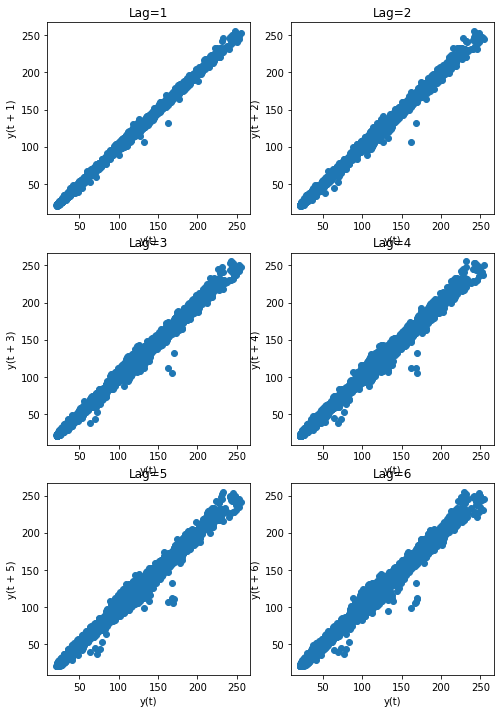

In [9]:
# Plot lags to see if arima makes sense
lag_auto_plot(trainDataDay)

### Determine p, d and q

In [10]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(trainDataDay)
#print(p_val, should_diff) #0.07508082249027766 True

In [11]:
kpss_diffs = ndiffs(trainDataDay, alpha=0.05, test='kpss', max_d=6) #Kwiatkowski–Phillips–Schmidt–Shin-Test
adf_diffs = ndiffs(trainDataDay, alpha=0.05, test='adf', max_d=6) #Augmented Dickey-Fuller-Test
n_diffs = max(adf_diffs, kpss_diffs) #Get max value of both tests

#print(f"Estimated differencing term: {n_diffs}") # Estimated differencing term: 1

In [12]:
#autoArimaDay = pm.auto_arima(trainDataDay, 
#                     d=n_diffs, # Number of differentiation
#                     max_q = 5, #Max Number of Moving Average terms
#                     max_p=5, #Max Number of Auto Regression terms
#                     seasonal=False, #Non seasonal data
#                     stepwise=True, #Grid search
#                     suppress_warnings=True, 
#                     max_order=None, #No constraints for max order (p+q+P+Q)
#                     method='powell',# modified Powell’s method
#                     trace=True # Show tests
#                    )
#Best model:  ARIMA(1,1,1)(0,0,0)[0]   

autoArimaDay = pm.ARIMA(order=(1,n_diffs,1), method="powell")
autoArimaDay.fit(trainDataDay, maxiter=200)


ARIMA(method='powell', order=(1, 1, 1))

### Forecast data

In [13]:
forecastsDay, conf_intDay = forecast_and_update_model(autoArimaDay, testDataDay)

### Plot Prediction vs Actual

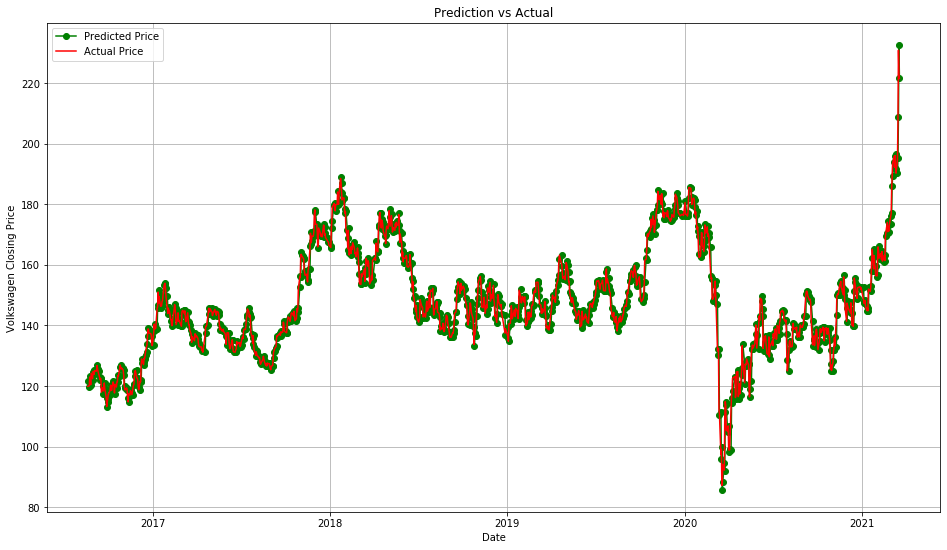

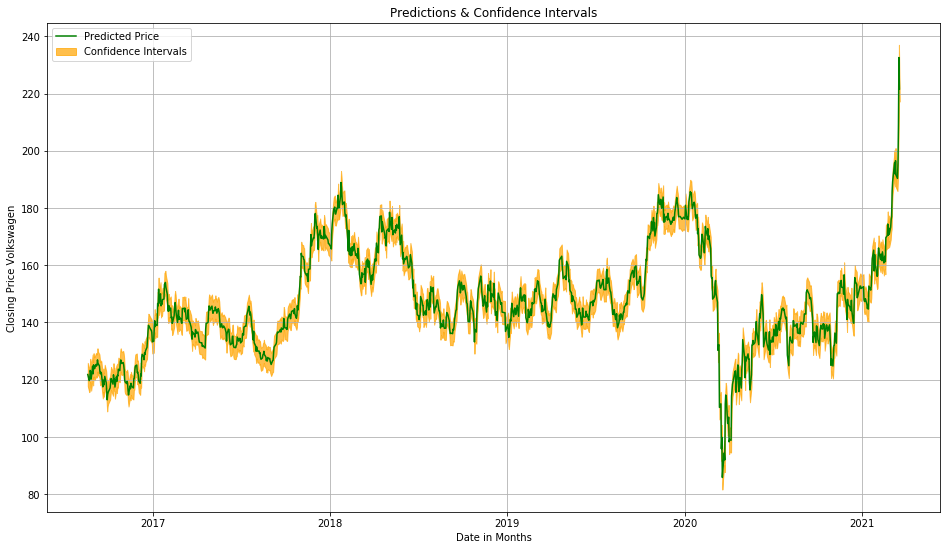

In [14]:
plot_prediction_vs_actual(trainDataDay, testDataDay, forecastsDay, conf_intDay)

### Evaluate model

In [15]:
evaluate_model(testDataDay, forecastsDay)

# Mean squared error: 8.76632079464574
# Mean absolut error: 2.0414405185952185
# SMAPE: 1.4042308619158148

Mean squared error: 8.765248364767613
Mean absolut error: 2.0417516365075223
SMAPE: 1.4043674720716213


## Month Data

In [16]:
dfDataMonth = dfDataOrig.copy() #Create a copy, so the original data is not modified
dfDataMonth = dfDataMonth[["Close"]] # Keep only the Close column
dfDataMonth = dfDataMonth.resample("M").mean() #Resample the data to get the mean for each month in a year

#print(dfDataMonth.head(5))
#print(dfDataMonth.tail(5))
#print(dfDataMonth.shape) #(273, 1)
#print(dfDataMonth.index) # dtype='datetime64[ns]', name='Date', length=5803, freq=None

### Split in training und test data

In [17]:
index = round(0.8*len(dfDataMonth)) #Use 80% for training
trainDataMonth = dfDataMonth[:index] 
testDataMonth = dfDataMonth[index:]

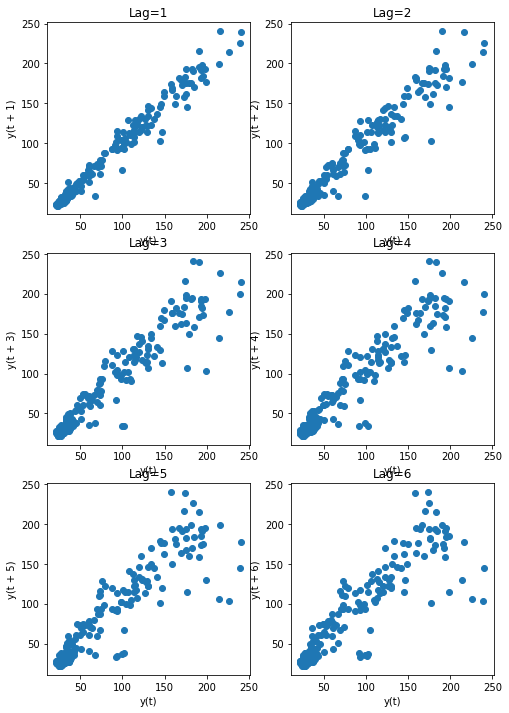

In [18]:
# Plot lags to see if arima makes sense
lag_auto_plot(trainDataMonth) #No linear shape -> Auto Regression not a good choice

### Determine p, d and q

In [19]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(trainDataMonth)
print(p_val, should_diff) #0.2847947032599953 True

0.2847947032599953 True


In [20]:
kpss_diffs = ndiffs(trainDataMonth, alpha=0.05, test='kpss', max_d=6) #Kwiatkowski–Phillips–Schmidt–Shin-Test
adf_diffs = ndiffs(trainDataMonth, alpha=0.05, test='adf', max_d=6) #Augmented Dickey-Fuller-Test
n_diffs = max(adf_diffs, kpss_diffs) #Get max value of both tests

#print(f"Estimated differencing term: {n_diffs}") # Estimated differencing term: 1

In [21]:
#autoArimaMonth = pm.auto_arima(trainDataMonth, 
#                     d=n_diffs, # Number of differentiation
#                     max_q = 5, #Max Number of Moving Average terms
#                     max_p=5, #Max Number of Auto Regression terms
#                     seasonal=False, #Non seasonal data
#                     stepwise=True, #Grid search
#                     suppress_warnings=True, 
#                     max_order=None, #No constraints for max order (p+q+P+Q)
#                     method='powell',# modified Powell’s method
#                     trace=True # Show tests
#                    )
#Best model:  ARIMA(0,1,1)(0,0,0)[0] 

autoArimaMonth = pm.ARIMA(order=(0,n_diffs,1), method="powell")
autoArimaMonth.fit(trainDataMonth, maxiter=200)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1549.111, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1566.607, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1548.660, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1544.005, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1564.834, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1545.278, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1545.303, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1547.387, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1542.138, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1543.428, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1543.452, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1546.776, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1545.523, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.085 seconds


### Forecast data

In [22]:
forecastsMonth, conf_intMonth = forecast_and_update_model(autoArimaMonth, testDataMonth)

### Plot Prediction vs Actual

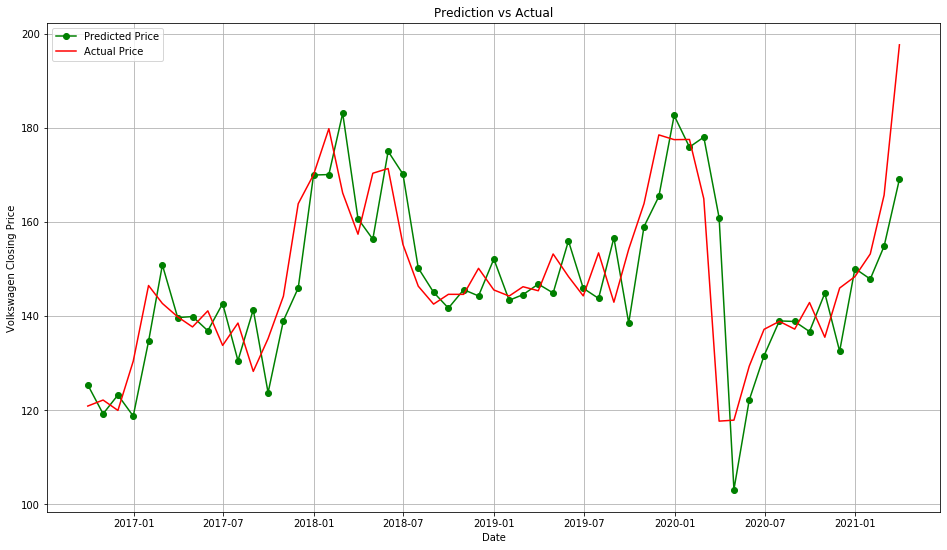

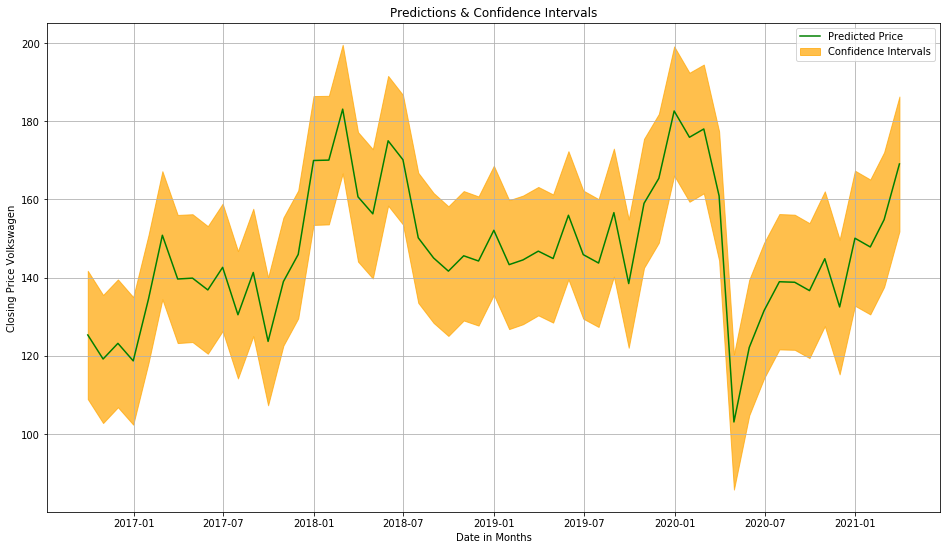

In [23]:
plot_prediction_vs_actual(trainDataMonth, testDataMonth, forecastsMonth, conf_intMonth)

### Evaluate model

In [24]:
evaluate_model(testDataMonth, forecastsMonth)

# Mean squared error: 120.84754399906895
# Mean absolut error: 8.102724236914167
# SMAPE: 5.496326143431561

Mean squared error: 120.84754399906895
Mean absolut error: 8.102724236914167
SMAPE: 5.496326143431561
